## 0. Imports and Data Loading

In [1]:
import warnings
import requests
import re

import pandas as pd 
import numpy as np

import statsmodels.formula.api as smf
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from src.models.ProteinModel import ProteinModel

import matplotlib.pyplot as plt
import seaborn as sns
import umap 
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [2]:
data_path = 'BindingDB_All.tsv'

In [3]:
# Data loading
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message=".*Specify dtype option on import or set low_memory=False.*")
    df = pd.read_csv(data_path, sep='\t', on_bad_lines='skip');
df.head()

,BindingDB Reactant_set_id,Ligand SMILES,Ligand InChI,Ligand InChI Key,BindingDB MonomerID,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Ki (nM),IC50 (nM),...,UniProt (SwissProt) Recommended Name of Target Chain.12,UniProt (SwissProt) Entry Name of Target Chain.12,UniProt (SwissProt) Primary ID of Target Chain.12,UniProt (SwissProt) Secondary ID(s) of Target Chain.12,UniProt (SwissProt) Alternative ID(s) of Target Chain.12,UniProt (TrEMBL) Submitted Name of Target Chain.12,UniProt (TrEMBL) Entry Name of Target Chain.12,UniProt (TrEMBL) Primary ID of Target Chain.12,UniProt (TrEMBL) Secondary ID(s) of Target Chain.12,UniProt (TrEMBL) Alternative ID(s) of Target Chain.12
0,1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,InChI=1S/C31H42N2O7/c34-27(35)17-9-3-11-19-32-...,XGEGDSLAQZJGCW-HHGOQMMWSA-N,608734,"6-[(4R,5S,6S,7R)-4,7-dibenzyl-3-(5-carboxypent...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,InChI=1S/C31H34N6O3/c38-29-27(17-23-9-3-1-4-10...,UZLMEAPBHYEHAC-UNTBESQGSA-N,22,"(4R,5S,6S,7R)-4,7-dibenzyl-5,6-dihydroxy-1,3-b...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,InChI=1S/C29H34N4O3/c34-27-25(16-21-8-3-1-4-9-...,HYNYUFZPPJMPOB-UTWJFGBXSA-N,23,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.41,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,InChI=1S/C29H40N2O4/c32-18-10-2-1-9-17-30-25(1...,YXVAZXDWVZTGGD-VIJSPRBVSA-N,24,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,InChI=1S/C28H38N2O4/c31-17-9-3-8-16-29-24(18-2...,WWTSWTPNILRSJX-XDZXDJIYSA-N,25,"(4R,5S,6S,7R)-4,7-dibenzyl-1-(cyclopropylmethy...",Dimer of Gag-Pol polyprotein [501-599],Human immunodeficiency virus 1,0.99,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----------------------------

## Aparté - Example of a problematic case
Sometimes, the same protein in the dataset has different amino acid sequence.
Below, we provide an example of such a case:

In [4]:
# Grouping by UniProt name and Target Name to compare sequences of the same protein
df_grouped_example = df.groupby(['Target Name', 'UniProt (SwissProt) Entry Name of Target Chain'])['BindingDB Target Chain Sequence'].apply(lambda x: x.unique())

# Focusing on the groups with at least two proteins that are shorter than 100 amnio acids lengths (For visualization simplicity)
df_grouped_example = df_grouped_example[df_grouped_example.apply(len) >= 2].reset_index()
example = df_grouped_example[df_grouped_example['BindingDB Target Chain Sequence'].apply(lambda x: len(x[0])) < 100].sample(1)

# Printing a problematic example
print('Example of a problematic case:')
print('Target Name: ', example['Target Name'].values[0])
print('UniProt (SwissProt) Entry Name of Target Chain: ', example['UniProt (SwissProt) Entry Name of Target Chain'].values[0])

for idx, seq in enumerate(example['BindingDB Target Chain Sequence'].values[0]):
    print(f'Sequence {idx}: ', seq)

Example of a problematic case:
Target Name:  Histone H3.1 [22-45]
UniProt (SwissProt) Entry Name of Target Chain:  H31_HUMAN
Sequence 0:  ATKAARKSAPATGGVKKPHRYRPG
Sequence 1:  ATKAARKSAPATGGVKKPHRYRPGGK


We see that this protein is a mutant of Histone H3.1 that has an exact length of 45-22+1 = 24  (given in the name). But the two sequences have a different length (24 and 26) which shows a problem. We ran into this issue by accident and dealing with it would be a very complicated task. We thus have decided to ignore it for sake of simplicity.

---------------


## 1. Data Exploration and Data Processing

Our study focuses on the relation between protein or ligan structure and binding affinity. We will thus retain certain features to have a more neat data file:
- the ID of the interaction in BindingDB
- the Ligand SMILES (which contains structural information)
- the protein target Name (which contains information about mutations)
- the protein target chain sequence (which contains structural information)
- the entry name of the target chain in UniProt (SwissProt)
- binding affinity features

### 1.1 Binding Affinity Metrics Sparsity
We first looked at the proportion of binding affinity metrics in BindingDB:

In [5]:
bindind_affinity_covariates = ['Ki (nM)', 'IC50 (nM)', 'Kd (nM)', 'EC50 (nM)', 'kon (M-1-s-1)', 'koff (s-1)']
for c in bindind_affinity_covariates:
    missing_rate = df[[c]].isna().sum().values/len(df[[c]])*100
    print(f"Missing {c} values percentage: {np.round(missing_rate[0], 2)}%")

Missing Ki (nM) values percentage: 79.74%
Missing IC50 (nM) values percentage: 33.11%
Missing Kd (nM) values percentage: 96.2%
Missing EC50 (nM) values percentage: 90.85%
Missing kon (M-1-s-1) values percentage: 99.97%
Missing koff (s-1) values percentage: 99.97%


There are a lot of missing values and to retain as much data as possible, we have decided to focus on IC50 (nM) values since it is the most available one. We initially also retained Ki (nM) as it is the second most available feature but we decided to not use it in the end given the fact that lot of data is missing and the relation between IC50 (nM) and Ki (nM) wasn't clear enough to use interpolation (see 1.4).

### 1.2 Target Chain Entry Sparsity

In [6]:
target_names = ['UniProt (SwissProt) Entry Name of Target Chain.{}'.format(i) for i in range(1,13)]
for t in target_names: 
    missing_rate = df[[t]].isna().sum().values/len(df[[t]]) * 100
    print(f"Missing values percentage for {t}: {np.round(missing_rate[0], 2)}% ")

Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.1: 94.72% 
Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.2: 98.78% 
Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.3: 99.47% 
Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.4: 99.71% 
Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.5: 99.87% 
Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.6: 99.89% 
Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.7: 99.89% 
Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.8: 99.9% 
Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.9: 99.92% 
Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.10: 99.92% 
Missing values percentage for UniProt (SwissProt) Entry Name of Target Chain.11: 100.0% 
Missing values percentage for U

Most proteins are composed of only one target chain. We have decided to focus on those as well because any analysis including other chains would lack data.

### 1.3 Data Filtering

In [7]:
# Focusing on proteins with a single chain
df = df[df['Number of Protein Chains in Target (>1 implies a multichain complex)'] == 1]

# Selecting a subset of columns of interest
useful_cols = ['BindingDB Reactant_set_id', 'Ligand SMILES', 'Target Name', 'IC50 (nM)', 'Ki (nM)', 
'BindingDB Target Chain Sequence', 'UniProt (SwissProt) Entry Name of Target Chain']

filtered_df = df[useful_cols]
filtered_df.set_index('BindingDB Reactant_set_id', inplace=True)
filtered_df.head()

,Ligand SMILES,Target Name,IC50 (nM),Ki (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain
BindingDB Reactant_set_id,,,,,,
1,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CCCCCC(O)=...,Dimer of Gag-Pol polyprotein [501-599],NaN,0.24,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,POL_HV1BR
2,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn...,Dimer of Gag-Pol polyprotein [501-599],NaN,0.25,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,POL_HV1BR
3,O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=...,Dimer of Gag-Pol polyprotein [501-599],NaN,0.41,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,POL_HV1BR
4,OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@...,Dimer of Gag-Pol polyprotein [501-599],NaN,0.8,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,POL_HV1BR
5,OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H...,Dimer of Gag-Pol polyprotein [501-599],NaN,0.99,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...,POL_HV1BR


### 1.4 Formatting affinity features entries and analysis of their relation

Looking at the types of entries for IC50

In [8]:
filtered_df['IC50 (nM)'].value_counts()

IC50 (nM)
>10000     60546
<100       49049
>100000    34956
 550       22131
>1000      21222
           ...  
 153.73        1
 89.04         1
 21.53         1
 113.71        1
 30750         1
Name: count, Length: 58351, dtype: int64

As we can see, there are many ways IC50 values are stored in this database. Not all of them can be compared.

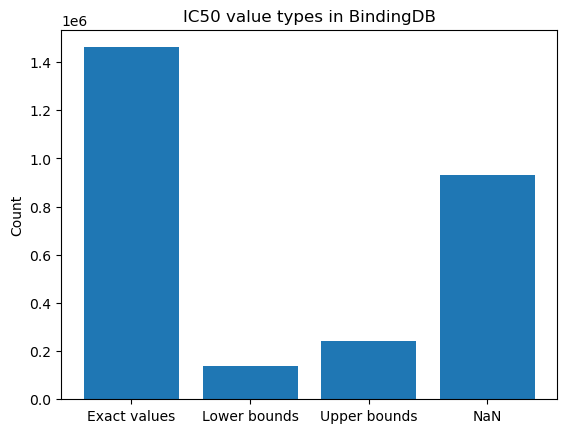

In [9]:
# Grouping entries with mathematical symbols
upper_bound_ic50_values = filtered_df[filtered_df['IC50 (nM)'].apply(lambda x: type(x)==str and '>' in x)]
lower_bound_ic50_values = filtered_df[filtered_df['IC50 (nM)'].apply(lambda x: type(x)==str and '<' in x)]
nan_ic50_values = filtered_df[filtered_df['IC50 (nM)'].isna()]
number_of_exact_ic50_values = len(filtered_df)-len(upper_bound_ic50_values)-len(lower_bound_ic50_values)-len(nan_ic50_values)

# PLotting the proportion of each category
names = ['Exact values', 'Lower bounds', 'Upper bounds', 'NaN']
vals = [number_of_exact_ic50_values, len(lower_bound_ic50_values), len(upper_bound_ic50_values), len(nan_ic50_values)]
plt.bar(names, vals)
plt.ylabel('Count')
plt.title('IC50 value types in BindingDB');

We obviously have to drop rows with NaN IC50 values. This analysis also shows us that most entries have an exact IC50 values and it is thus valid to focus on those. 

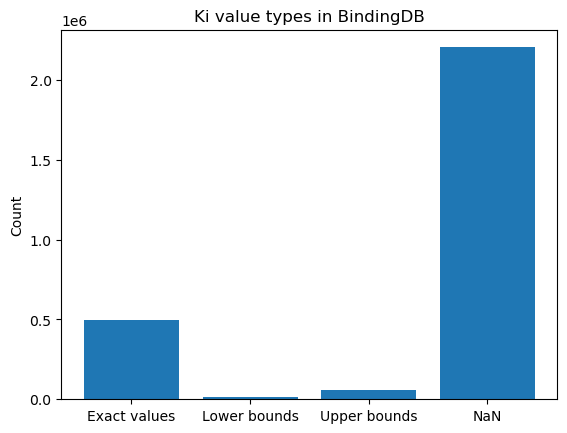

In [10]:
# Grouping entries with mathematical symbols
upper_bound_ki_values = filtered_df[filtered_df['Ki (nM)'].apply(lambda x: type(x)==str and '>' in x)]
lower_bound_ki_values = filtered_df[filtered_df['Ki (nM)'].apply(lambda x: type(x)==str and '<' in x)]
nan_ki_values = filtered_df[filtered_df['Ki (nM)'].isna()]
number_of_exact_ki_values = len(filtered_df)-len(upper_bound_ki_values)-len(lower_bound_ki_values)-len(nan_ki_values)

# PLotting the proportion of each category
names = ['Exact values', 'Lower bounds', 'Upper bounds', 'NaN']
vals = [number_of_exact_ki_values, len(lower_bound_ki_values), len(upper_bound_ki_values), len(nan_ki_values)]
plt.bar(names, vals)
plt.ylabel('Count')
plt.title('Ki value types in BindingDB');

We see here that the story is quite different and most values are NaN.

We decided to still investigate the relation between those two affinity metrics as it could be useful for data interpolation.

In [11]:
# Filtering out values that do not match an exact value (IC50 or Ki)
def filter_out_comparator(s):
    """
    Filtering out values that do not match an exact IC50 or Ki value
    :param s: IC50 or Ki value
    :return bool: False if the IC50 or Ki entry contains a mathematical symbol, True otherwise
    """
    if type(s)==str and ('>' in s or '<' in s):
        return False
    else:
        return True

In [12]:
# Creating a filtered dataframe for IC50 (nM) (keeping only exact values)
clean_df = filtered_df.copy()
clean_df = clean_df[clean_df['IC50 (nM)'].apply(filter_out_comparator)]
clean_df['IC50 (nM)'] = pd.to_numeric(clean_df['IC50 (nM)'], errors='coerce')
clean_df = clean_df.dropna(subset=['IC50 (nM)'])
clean_df.head()

,Ligand SMILES,Target Name,IC50 (nM),Ki (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain
BindingDB Reactant_set_id,,,,,,
145,O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...,Galactokinase,6676.9,NaN,MAALRQPQVAELLAEARRAFREEFGAEPELAVSAPGRVNLIGEHTD...,GALK1_HUMAN
181,CC(C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)[C@@...,Dimer of Gag-Pol polyprotein [489-587],8.5,NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5
182,CCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1)[...,Dimer of Gag-Pol polyprotein [489-587],177.0,NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5
184,COCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1...,Dimer of Gag-Pol polyprotein [489-587],164.0,NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5
185,COCCOCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccc...,Dimer of Gag-Pol polyprotein [489-587],67.0,NaN,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5


In [13]:
# Creating a filtered dataframe for Ki (nM) (keeping only exact values)
clean_df_ki = filtered_df.copy()
clean_df_ki = clean_df_ki[clean_df_ki['Ki (nM)'].apply(filter_out_comparator)]
clean_df_ki['Ki (nM)'] = pd.to_numeric(clean_df['Ki (nM)'], errors='coerce')
clean_df_ki = clean_df_ki.dropna(subset=['Ki (nM)'])
clean_df_ki.head()

,Ligand SMILES,Target Name,IC50 (nM),Ki (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain
BindingDB Reactant_set_id,,,,,,
442,CC(C)C1(CCc2ccc(O)cc2)CC(=O)C(Sc2cc(C)c(N)cc2C...,Dimer of Gag-Pol polyprotein [489-587],2.7,0.670,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5
444,CC(C)C1(CCc2ccc(O)cc2)CC(=O)C(Sc2cc(C)c(NS(=O)...,Dimer of Gag-Pol polyprotein [489-587],1.8,0.530,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5
449,CC(C)C1(CCc2ccc(O)cc2)CC(=O)C(Sc2cc(C)c(NS(=O)...,Dimer of Gag-Pol polyprotein [489-587],2.2,0.410,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5
767,CC(C)[C@H](NC(=O)c1ccc2ccccc2n1)C(=O)N[C@@H](C...,Dimer of Gag-Pol polyprotein [489-587],4,0.031,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,POL_HV1N5
768,CC(C)[C@H](NC(=O)c1ccc2ccccc2n1)C(=O)N[C@@H](C...,Dimer of Gag-Pol polyprotein [514-612],10,0.130,PQFSLWKRPVVTAYIEGQPVEVLLDTGADDSIVAGIELGNNYSPKI...,POL_HV2RO


In [14]:
# Inner join to retain only entries with an exact value of IC50 and an exact value of Ki
joint_df_ki_ic50 = pd.merge(left=clean_df, right=clean_df_ki, how='inner', on=['Ligand SMILES', 'Target Name', 'BindingDB Target Chain Sequence','UniProt (SwissProt) Entry Name of Target Chain'])
joint_df_ki_ic50.drop(columns = ['Ki (nM)_x', 'IC50 (nM)_y'], inplace=True)
joint_df_ki_ic50.columns = ['Ligand SMILES', 'Target Name', 'IC50 (nM)','BindingDB Target Chain Sequence','UniProt (SwissProt) Entry Name of Target Chain', 'Ki (nM)']

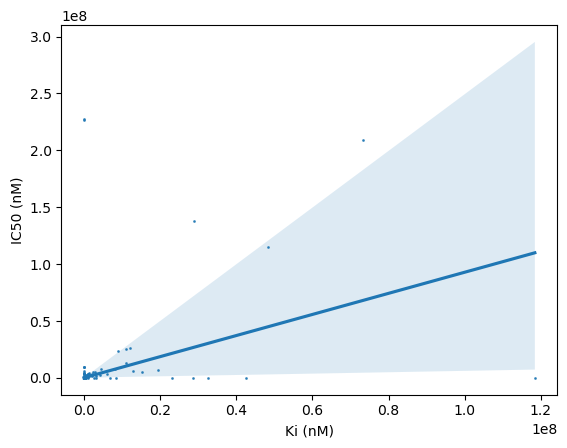

In [15]:
# Linear regression between Ki and IC50
sns.regplot(data=joint_df_ki_ic50, x='Ki (nM)', y='IC50 (nM)', scatter_kws={'s':1});

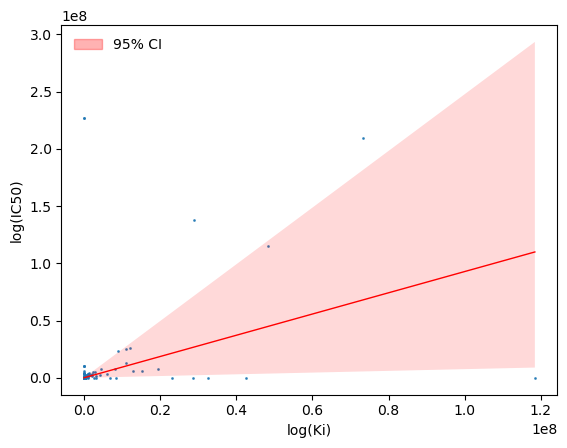

In [16]:
# Linear regression between log(Ki) and log(IC50)
log_joint_df_ki_ic50 = joint_df_ki_ic50.copy()
log_joint_df_ki_ic50[['log(Ki (nM))', 'log(IC50 (nM))']] = joint_df_ki_ic50[['Ki (nM)', 'IC50 (nM)']].apply(np.log)
sns.regplot(x=log_joint_df_ki_ic50['Ki (nM)'], y=log_joint_df_ki_ic50['IC50 (nM)'], ci=95, scatter_kws={'s':1}, line_kws={'color':'r', 'linewidth':1})
plt.xlabel('log(Ki)')
plt.ylabel('log(IC50)')
ci_patch = mpatches.Patch(color='red', alpha=0.3, label='95% CI')
plt.legend(handles=[ci_patch], loc='upper left', frameon=False);

In [17]:
mod = smf.ols(formula='Q("IC50 (nM)") ~ Q("Ki (nM)")', data=log_joint_df_ki_ic50)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         Q("IC50 (nM)")   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     904.1
Date:                Thu, 14 Nov 2024   Prob (F-statistic):          8.36e-185
Time:                        20:02:30   Log-Likelihood:                -98655.
No. Observations:                5844   AIC:                         1.973e+05
Df Residuals:                    5842   BIC:                         1.973e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.184e+05    6.8e+04      1.741   

We will thus not use Ki (nM) since only a small part of the dataset has entries for it and the $R^2$ value being very low, we could not use data interpolation to fill out missing values.

In [18]:
clean_df.drop(columns=['Ki (nM)'], inplace=True)

### 1.5 Exploring the amount of different entries for a given interaction

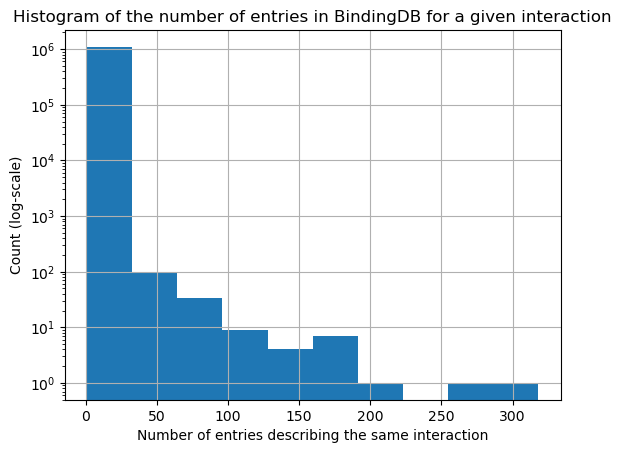

In [19]:
# Grouping all the entries that focus on the same interaction
grouped_by_interactions = clean_df.groupby(['Ligand SMILES', 'Target Name', 'BindingDB Target Chain Sequence', 
                                            'UniProt (SwissProt) Entry Name of Target Chain'])['IC50 (nM)'].count().reset_index()
grouped_by_interactions['IC50 (nM)'].hist(log=True)

# Plotting the histogram to show the amount of entries
plt.title('Histogram of the number of entries in BindingDB for a given interaction')
plt.xlabel('Number of entries describing the same interaction')
plt.ylabel('Count (log-scale)');

This plot shows us that some interactions have multiple entries in BindingDB. We thus need to merge the values to have only one entry per interaction. To have a robust merged value, we have decided to use the median which is less sensitive to outliers compared to the mean. 
Once this is done, we save this dataframe into a csv file which contains all the processed data.

In [20]:
# Merging all the different entries using the median of each group
merged_df = clean_df.groupby(['Ligand SMILES', 'Target Name', 'BindingDB Target Chain Sequence', 
                              'UniProt (SwissProt) Entry Name of Target Chain'])['IC50 (nM)'].median().reset_index()

# Exporting the dataframe to a .csv
merged_df.to_csv('data/merged_df.csv')
merged_df.head()

,Ligand SMILES,Target Name,BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50 (nM)
0,B.CP(c1ccccc1)c1ccc(O)cc1,Estrogen receptor,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,ESR1_HUMAN,9800.0
1,B.CP(c1ccccc1)c1ccc(O)cc1,Estrogen receptor beta,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,ESR2_HUMAN,2500.0
2,B.Oc1ccc(cc1)P(c1ccccc1)c1ccccc1,Estrogen receptor,MTMTLHTKASGMALLHQIQGNELEPLNRPQLKIPLERPLGEVYLDS...,ESR1_HUMAN,12000.0
3,B.Oc1ccc(cc1)P(c1ccccc1)c1ccccc1,Estrogen receptor beta,MDIKNSPSSLNSPSSYNCSQSILPLEHGSIYIPSSYVDSHHEYPAM...,ESR2_HUMAN,2000.0
4,B[P@@]1(=O)OC[C@H]2O[C@H]([C@@H](F)C2O[P@@](B)...,Stimulator of interferon genes protein [140-379],APAEISAVCEKGNFNVAHGLAWSYYIGYLRLILPELQARIRTYNQH...,STING_HUMAN,5470.0


### 1.6 Various Distributions

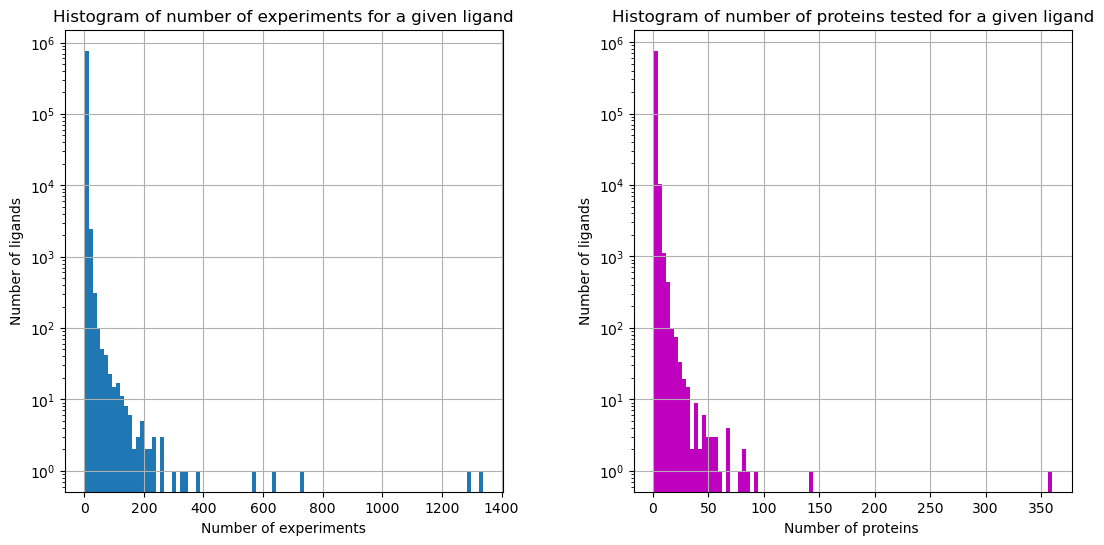

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
clean_df['Ligand SMILES'].value_counts().hist(bins=100, log=True, ax=axs[0])
axs[0].set_title('Histogram of number of experiments for a given ligand')
axs[0].set_xlabel('Number of experiments')
axs[0].set_ylabel('Number of ligands');

prot_per_lig = clean_df.groupby('Ligand SMILES')['Target Name'].nunique().reset_index()
prot_per_lig.hist(bins=100, log=True, ax=axs[1], color='m')
axs[1].set_title('Histogram of number of proteins tested for a given ligand')
axs[1].set_xlabel('Number of proteins ')
axs[1].set_ylabel('Number of ligands');

---------------

## 2. Mutant Analysis

Some parts of our study focuses only on mutants and we thus will process the data further to store this information in another file. 
First, we look at the distribution of the number of mutants for a given ligand and a given wild-type (WT) protein.
In BindingDB, two mutants will share the same 'UniProt (SwissProt) Entry Name of Target Chain' value but the 'Target Name' value will be different and indicate the type and location of mutations.

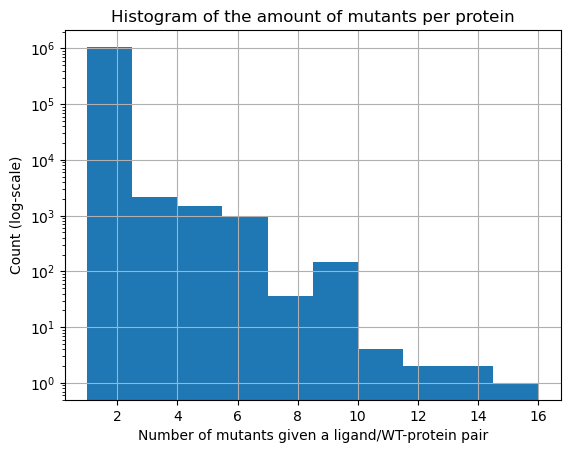

In [22]:
merged_df.groupby(['Ligand SMILES', 'UniProt (SwissProt) Entry Name of Target Chain']).count().reset_index()['Target Name'].hist(log=True)
plt.xlabel('Number of mutants given a ligand/WT-protein pair')
plt.ylabel('Count (log-scale)');
plt.title('Histogram of the amount of mutants per protein');

This histogram shows that most entries correspond to an interaction between a given ligand A and a given WT protein B where no mutants of B were tested against A. We thus have to filter out these interaction to focus on groups that have at least 2 values (the WT protein and a mutant)

In [23]:
# Filtering out proteins that do not have any mutant
mutants_filtered_df = merged_df.groupby(['Ligand SMILES', 'UniProt (SwissProt) Entry Name of Target Chain']).filter(lambda x: len(x) >= 2)

# Creating a new dataframe with the filtered entries
merged_mutants_filtered_df = mutants_filtered_df.groupby(['Ligand SMILES', 'UniProt (SwissProt) Entry Name of Target Chain']).apply(lambda x: pd.Series({
    'Target Names': list(x['Target Name']),
    'BindingDB Target Chain Sequence': list(x['BindingDB Target Chain Sequence'])}), include_groups=False).reset_index()
merged_mutants_filtered_df.head()

,Ligand SMILES,UniProt (SwissProt) Entry Name of Target Chain,Target Names,BindingDB Target Chain Sequence
0,Brc1cc(CN2CCC(CC2)N2CC(CC#N)(C2)n2cc(cn2)-c2nc...,JAK2_HUMAN,"[Tyrosine-protein kinase JAK2 [828-1132], Tyro...",[ALGFSGAFEDRDPTQFEERHLKFLQQLGKGNFGSVEMCRYDPLQD...
1,Brc1cc(CN2CCC(CC2)N2CC(CC#N)(C2)n2cc(cn2)-c2nc...,JAK2_HUMAN,"[Tyrosine-protein kinase JAK2 [828-1132], Tyro...",[ALGFSGAFEDRDPTQFEERHLKFLQQLGKGNFGSVEMCRYDPLQD...
2,Brc1ccc(\C=C\CNCCOc2cncc(\C=C\c3ccncc3)c2)cc1,AKT1_HUMAN,"[RAC-alpha serine/threonine-protein kinase, RA...",[MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDV...
3,Brc1ccc2OCc3noc(=O)n3-c2c1,PVDQ_PSEAE,"[Acyl-homoserine lactone acylase PvdQ, Acyl-ho...",[MGMRTVLTGLAGMLLGSMMPVQADMPRPTGLAADIRWTAYGVPHI...
4,Brc1ccc2n(CC(=O)NC3CN(C3)C(=O)C=C)cc(C(=O)N3CC...,RASK_HUMAN,"[GTPase KRas, GTPase KRas [1-169,G12C,C118A]]",[MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVV...


For some analysis, we need to know which protein is the WT and which ones are the mutants. To do so, we query UniProt, retrieve the protein name using 'UniProt (SwissProt) Entry Name of Target Chain' and we check if the WT protein was tested against the given ligand. We filter out all the rows for which this is not the case since we can't perform any analysis if we don't have IC50 value for the WT against the given ligand.

In [24]:
def get_protein_name(entry_name):
    """
    Retrieveing protein name from UniProt
    :param entry_name: UniProt name of the Target Chain in BindingDB
    :return protein_name: Protein name of the mutant
    """
    url = f"https://rest.uniprot.org/uniprotkb/{entry_name}.json"
    
    response = requests.get(url)
    
    # Check if the response was successful
    if response.status_code == 200:
        data = response.json()
        # Extract the protein name
        protein_name = data['proteinDescription']['recommendedName']['fullName']['value']
        return protein_name
    else:
        print(f"Entry '{entry_name}' not found or an error occurred.")
        return None

In [25]:
# Applying the "get_protein_name" function to the dataframe to retrieve the wild type Name
protein_names = {entry: get_protein_name(entry) for entry in merged_mutants_filtered_df['UniProt (SwissProt) Entry Name of Target Chain'].unique()}
merged_mutants_filtered_df['WT Target Name'] = merged_mutants_filtered_df.apply(lambda x: protein_names.get(x['UniProt (SwissProt) Entry Name of Target Chain'], None) 
                                 if protein_names.get(x['UniProt (SwissProt) Entry Name of Target Chain'], None) in x['Target Names'] else None, axis=1)
merged_mutants_filtered_df.dropna(subset=['WT Target Name'], inplace=True)
merged_mutants_filtered_df.head()

,Ligand SMILES,UniProt (SwissProt) Entry Name of Target Chain,Target Names,BindingDB Target Chain Sequence,WT Target Name
2,Brc1ccc(\C=C\CNCCOc2cncc(\C=C\c3ccncc3)c2)cc1,AKT1_HUMAN,"[RAC-alpha serine/threonine-protein kinase, RA...",[MSDVAIVKEGWLHKRGEYIKTWRPRYFLLKNDGTFIGYKERPQDV...,RAC-alpha serine/threonine-protein kinase
3,Brc1ccc2OCc3noc(=O)n3-c2c1,PVDQ_PSEAE,"[Acyl-homoserine lactone acylase PvdQ, Acyl-ho...",[MGMRTVLTGLAGMLLGSMMPVQADMPRPTGLAADIRWTAYGVPHI...,Acyl-homoserine lactone acylase PvdQ
4,Brc1ccc2n(CC(=O)NC3CN(C3)C(=O)C=C)cc(C(=O)N3CC...,RASK_HUMAN,"[GTPase KRas, GTPase KRas [1-169,G12C,C118A]]",[MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVV...,GTPase KRas
5,Brc1ccc2n(CC(=O)NC3CN(C3)C(=O)C=C)cc(C(=O)NCCc...,RASK_HUMAN,"[GTPase KRas, GTPase KRas [1-169,G12C,C118A]]",[MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVV...,GTPase KRas
6,Brc1ccc2n(CC(=O)NC3CN(C3)C(=O)C=C)cc(C(=O)NCc3...,RASK_HUMAN,"[GTPase KRas, GTPase KRas [1-169,G12C,C118A]]",[MTEYKLVVVGAGGVGKSALTIQLIQNHFVDEYDPTIEDSYRKQVV...,GTPase KRas


In [26]:
# Exporting the dataframe to a csv file
merged_mutants_filtered_df.to_csv('data/mutants.csv')

## 3. Protein Analysis

### 3.1. Preprocessing

#### 3.1.1 Grouping by Protein Group
The goal is to read the "Target Name" entry of each protein to try to label the protein in the major Groups (e.g. kinase, receptor, etc.)

In [27]:
# Precompile regular expressions and organize them in a dictionary to improve search efficiency
categories = {
    "Kinase": re.compile(r'kinase|akt|mapk|cdk|jak|trk|src'),
    "Receptor": re.compile(r'receptor|gpcr|serotonin|dopamine|glutamate|adrenergic|opioid'),
    "Synthase": re.compile(r'synthase|synthetase|carboxylase|dehydratase'),
    "Ligase": re.compile(r'ligase|carboxylase|dna ligase'),
    "Oxidase": re.compile(r'oxidase|oxygenase|peroxidase|cytochrome'),
    "Transferase": re.compile(r'transferase|methyltransferase|phosphotransferase|acetyltransferase'),
    "Hydrolase": re.compile(r'hydrolase|phosphatase|protease|lipase|esterase|nuclease'),
    "Enzyme": re.compile(r'enzyme|dehydrogenase|isomerase|lyase'),
    "Ion Channel": re.compile(r'channel|ion channel|potassium|sodium|calcium|chloride'),
    "Transporter": re.compile(r'transporter|abc transporter|slc transporter|solute carrier'),
    "Chaperone": re.compile(r'chaperone|heat shock protein|hsp'),
    "Structural Protein": re.compile(r'actin|tubulin|collagen|elastin'),
    "Signaling Protein": re.compile(r'g-protein|adapter protein|scaffold protein'),
    "Antibody": re.compile(r'antibody|immunoglobulin|igg|igm|iga'),
    "Transcription Factor": re.compile(r'transcription factor|p53|nf-kb|homeobox|hox|forkhead'),
    "Growth Factor / Cytokine": re.compile(r'growth factor|cytokine|interleukin|tnf|vegf|egf|fgf'),
    "Protease Inhibitor": re.compile(r'protease inhibitor|serpin'),
    "Hormone": re.compile(r'hormone|insulin|glucagon|erythropoietin|epo'),
    "Viral Replicase Polyprotein": re.compile(r'replicase polyprotein 1ab|replicase polyprotein 1a'),
    "Viral Genome Polyprotein": re.compile(r'genome polyprotein'),
    "Huntingtin": re.compile(r'huntingtin')
}

# Function to categorize based on precompiled regex patterns
def categorize_targets(name):
    """
    Categorizes each protein into a group based on its name
    :param name (str): target protein name
    :return: the category the protein has been labeled 
    """
    name = name.lower()
    for category, pattern in categories.items():
        if pattern.search(name):
            return category
    return "Other"

In [28]:
# Creating a new column in the dataframe
df = merged_df.copy(deep=True)
df['Protein Group'] = df['Target Name'].apply(categorize_targets)

# Get counts by category
target_counts = df['Protein Group'].value_counts()
print(target_counts)

Protein Group
Other                          272671
Kinase                         258332
Receptor                       253697
Hydrolase                       86730
Oxidase                         46707
Ion Channel                     43854
Enzyme                          32064
Transferase                     31734
Synthase                        30129
Structural Protein               9731
Ligase                           7666
Viral Replicase Polyprotein      7009
Transporter                      5343
Viral Genome Polyprotein         2699
Chaperone                        2629
Antibody                         1388
Growth Factor / Cytokine         1310
Transcription Factor             1114
Huntingtin                        281
Signaling Protein                 254
Hormone                            45
Protease Inhibitor                 36
Name: count, dtype: int64


As can be observed above, although the grouping has attempted to incorporate an extensive amount of groups (and acronyms for each groups), a large proportion of proteins is not categorized in these groups.

#### 3.1.2 Identifying Unlabelled Proteins
Unfortunately, an inclusion of more protein groups is difficult. Alternative options will be explored for P3.

In [29]:
df[df['Protein Group']== 'Other'][['Target Name', 'UniProt (SwissProt) Entry Name of Target Chain']].sample(10)

,Target Name,UniProt (SwissProt) Entry Name of Target Chain
617835,Bromodomain-containing protein 4 [1-477],BRD4_HUMAN
583341,Beta-secretase 1,BACE1_HUMAN
708950,Neutrophil cytosol factor 1 [S99G],NCF1_HUMAN
278263,Coagulation factor VII,FA7_HUMAN
449539,Transitional endoplasmic reticulum ATPase,TERA_HUMAN
917306,Beta-secretase 1,BACE1_MOUSE
342196,Metallo-beta-lactamase type 2,BLAN1_KLEPN
686280,Eukaryotic translation initiation factor 4E-bi...,4EBP1_HUMAN
55397,Envelope glycoprotein gp160,ENV_HV1H2
284397,Catenin beta-1,CTNB1_HUMAN


#### 3.1.3 Registering Protein Amino Acid Sequence Length

In [30]:
df['target_chain_length'] = df['BindingDB Target Chain Sequence'].str.len()

### 3.2. Plotting Explorations

#### 3.2.1 Creating custom color maps for plotting purposes
The Group "Other" (unclassified proteins) is assigned the lightgrey color for visualization purposes

In [31]:
# Retrieve the target families and then create a custom colormap
target_group = df['Protein Group'].astype('category').cat.categories
index_other = target_group.get_loc('Other')
colors = plt.cm.viridis(np.linspace(0, 1, len(target_group)))
colors[index_other] = mcolors.to_rgba('lightgrey')  # Set the color for "Other" to lightgrey

# Create the custom colormap based on the parameters defined above
custom_cmap = mcolors.ListedColormap(colors)
color_dict = {group: color for group, color in zip(target_group, colors)}

# Manual legend creation using patches for each target group
patches = [mpatches.Patch(color=colors[i], label=target_group[i]) for i in range(len(target_group))]

#### 3.2.2 Histogram of Target Chain Lengths grouped by Target Group

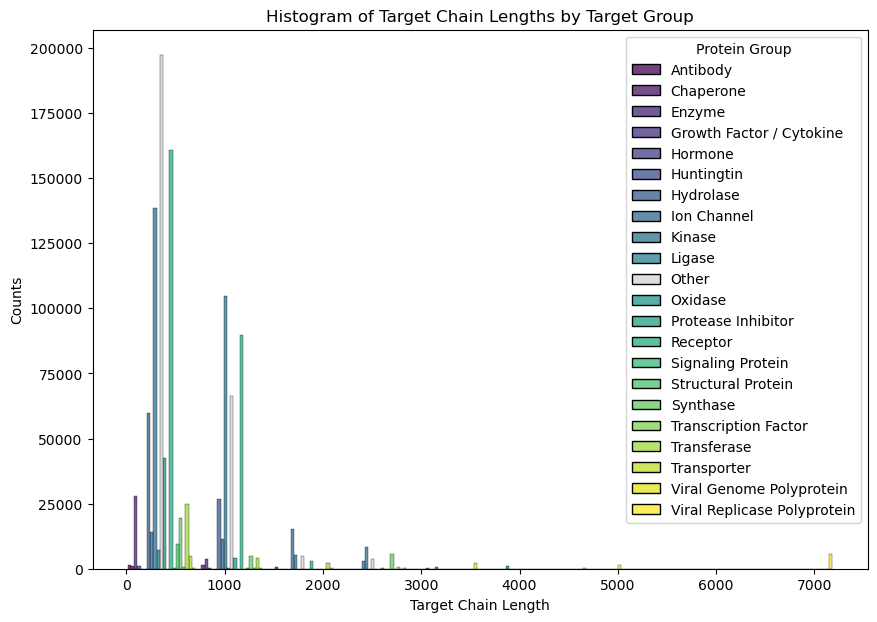

In [32]:
plt.figure(figsize=(10, 7))

# Plotting that respects the alphabetical order
sns.histplot(data=df, x='target_chain_length', bins=10, hue='Protein Group', multiple='dodge', palette=color_dict, hue_order = color_dict.keys())

plt.title('Histogram of Target Chain Lengths by Target Group')
plt.xlabel('Target Chain Length')
plt.ylabel('Counts')
plt.show()

#### 3.2.3 Boxplots IC50 or Protein Length in each Target Group
The goal is to try to observe any trend in data distribution across protein groups for the IC50 value and for the protein length

#### 3.2.3.A IC50

/Users/tancredicogne/anaconda3/envs/ada/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


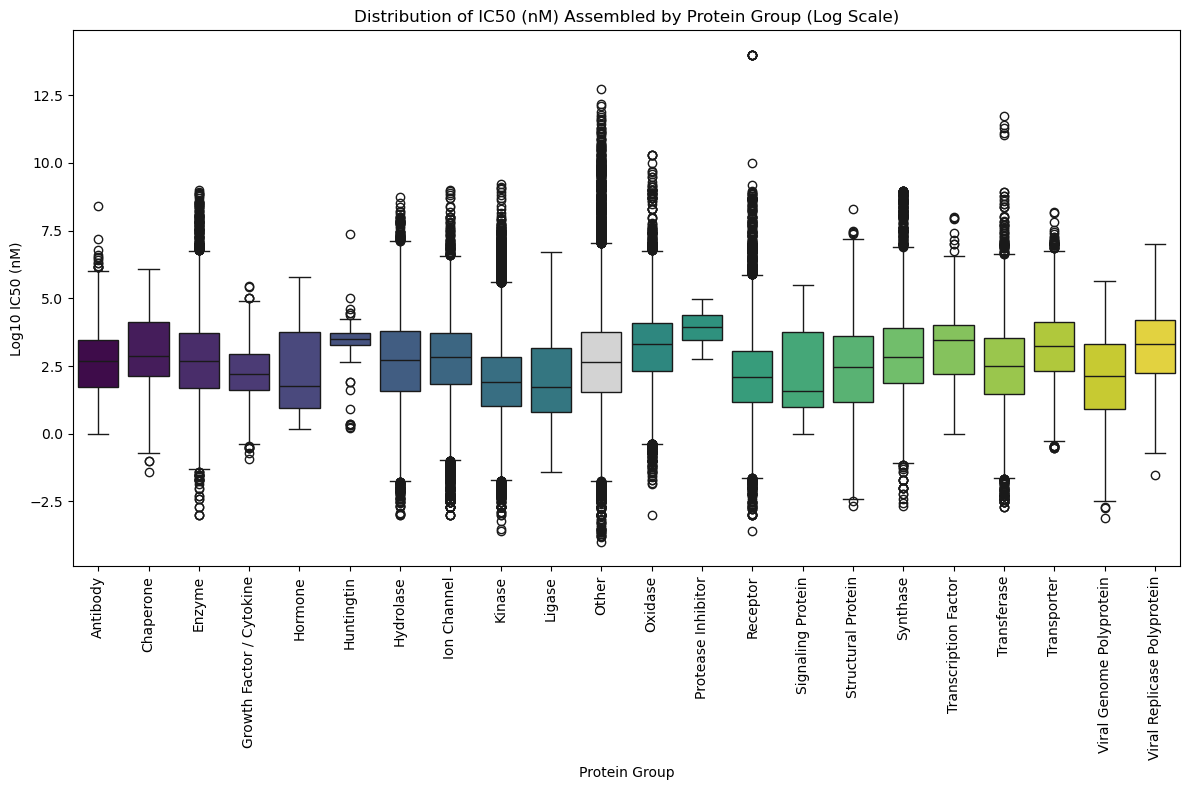

In [33]:
# Log-transform IC50 values for better scaling
df['Log_IC50 (nM)'] = np.log10(df['IC50 (nM)'])

plt.figure(figsize=(12, 8))

# Boxplot => Log_transformed IC50
sns.boxplot(
    data=df, x='Protein Group', y='Log_IC50 (nM)',
    order=color_dict.keys(), palette=color_dict, hue='Protein Group'
)

# Plotting param
plt.xticks(rotation=90)
plt.xlabel("Protein Group")
plt.ylabel("Log10 IC50 (nM)")
plt.title("Distribution of IC50 (nM) Assembled by Protein Group (Log Scale)")
plt.tight_layout()  # Used to avoid label overlap

plt.show()

On the above plot, no clear pattern of IC50 distribution emerges across protein groups.

#### 3.2.4.B Protein Length

We performed quantile transformation of features to follow a normal distribution: more frequent protein lengths will be spread out and the impact of outliers will be reduced.

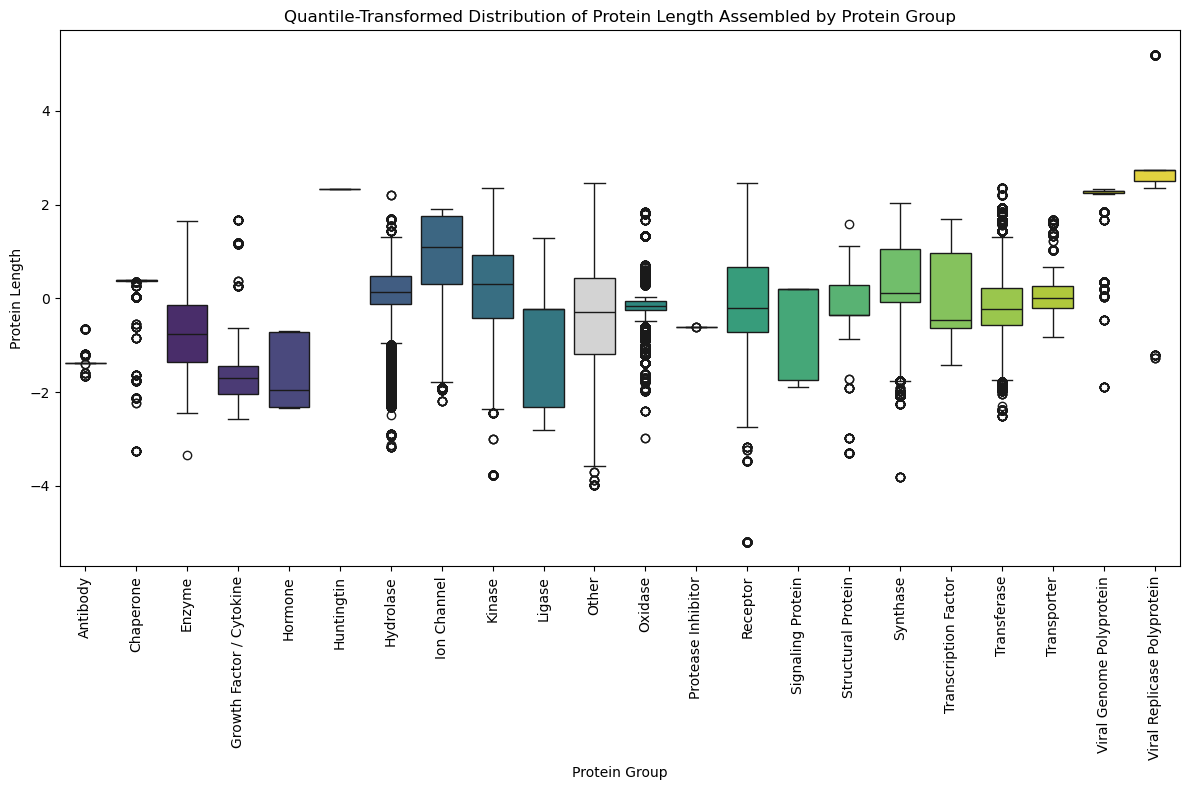

In [34]:
transformer = QuantileTransformer(output_distribution='normal')
df['Quantile_length'] = transformer.fit_transform(df[['target_chain_length']])

plt.figure(figsize=(12, 8))

# Boxplot => Quantile-Transformed Protein Length
sns.boxplot(
    data=df, x='Protein Group', y='Quantile_length',
    order=color_dict.keys(), palette=color_dict, hue='Protein Group'
)

# Plotting parameters
plt.xticks(rotation=90)
plt.xlabel("Protein Group")
plt.ylabel("Protein Length")
plt.title("Quantile-Transformed Distribution of Protein Length Assembled by Protein Group")
plt.tight_layout()  # Used to avoid label overlap

plt.show()

This distribution is more discriminating across protein groups. This information might be incorporated in further analysis for milestone 3.

### 3.3. Embedding the protein sequences onto a euclidean space

#### 3.3.1. Selecting the proteins tested against several ligands
Since our aim is to train a classifier on predicting high-affinity ligand groups, we should only use the proteins for which we can find a meaningful label, i.e. proteins for which we have several experiments available and can choose the best-binding ligands among several ligands. 

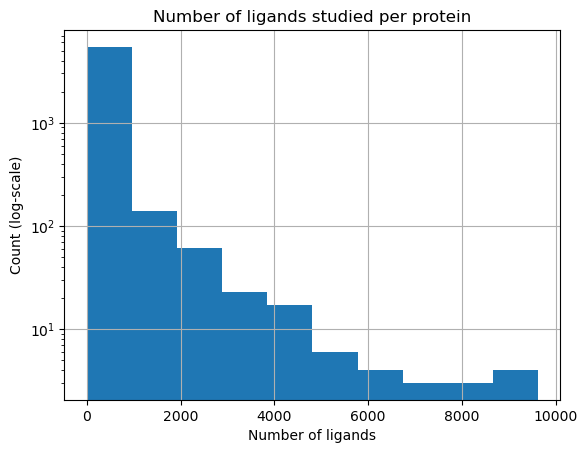

In [35]:
# Plotting the number of ligand SMILES per protein
grouped_by_proteins = merged_df.groupby(['Target Name', 'BindingDB Target Chain Sequence', 'UniProt (SwissProt) Entry Name of Target Chain'])['Ligand SMILES'].count().reset_index()
grouped_by_proteins['Ligand SMILES'].hist(log=True)
plt.title('Number of ligands studied per protein')
plt.xlabel('Number of ligands')
plt.ylabel('Count (log-scale)');

Based on those results, we could decide on using only proteins for which more than a certain amount of ligands have been studied, e.g. 10 ligands.

In [36]:
filtered_grouped_by_proteins = grouped_by_proteins.loc[grouped_by_proteins['Ligand SMILES'] > 10]

# Percentage of proteins remaining after the filtering
print(100*round(filtered_grouped_by_proteins.shape[0] / grouped_by_proteins.shape[0], 3), '% proteins remained after filtering.')

61.4 % proteins remained after filtering.


#### 3.3.2. Determine the best-binding ligands (i.e. lowest IC50)

The IC50 (half-maximal inhibitory concentration) value is a measure of the concentration of a drug or compound required to inhibit a particular biological or biochemical process by 50%. We use the fact that the lower the IC50 value, the better the binding affinity. 

In [37]:
best_ligand_idx = merged_df.groupby(['Target Name', 'BindingDB Target Chain Sequence', 'UniProt (SwissProt) Entry Name of Target Chain'])['IC50 (nM)'].idxmin().reset_index()
best_ligand_ic50 = merged_df.loc[best_ligand_idx['IC50 (nM)'], ['Target Name', 'BindingDB Target Chain Sequence', 'UniProt (SwissProt) Entry Name of Target Chain', 'Ligand SMILES', 'IC50 (nM)']]

# Take only proteins selected in 3.3.1.
filtered_best_ligand_ic50 = best_ligand_ic50.merge(filtered_grouped_by_proteins, on=['Target Name', 'BindingDB Target Chain Sequence', 'UniProt (SwissProt) Entry Name of Target Chain'], how='inner')

In [38]:
filtered_best_ligand_ic50

,Target Name,BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,Ligand SMILES_x,IC50 (nM),Ligand SMILES_y
0,"1,25-dihydroxyvitamin D(3) 24-hydroxylase, mit...",MSSPISKSRSLAAFLQQLRSPRQPPRLVTSTAYTSPQPREVPVCPL...,CP24A_HUMAN,Clc1cccc(c1)C(c1ccc2nc[nH]c2c1)n1ccnc1,2.30,80
1,"1,3-beta-glucan synthase component GSC2",MSYNDPNLNGQYYSNGDGTGDGNYPTYQVTQDQSAYDEYGQPIYTQ...,FKS2_YEAST,CCC(C)CC(C)CCCCCCCCC(=O)N[C@@H]1C[C@@H](O)CNC(...,30.00,32
2,"1,4-dihydroxy-2-naphthoyl-CoA synthase",MVAPAGEQGRSSTALSDNPFDAKAWRLVDGFDDLTDITYHRHVDDA...,MENB_MYCTU,CC(C)(COP(O)(=O)OP(O)(=O)OC[C@H]1O[C@H]([C@H](...,103.00,27
3,"1,5-anhydro-D-fructose reductase",MGDIPAVGLSSWKASPGKVTEAVKEAIDAGYRHFDCAYFYHNEREV...,AKCL2_HUMAN,Cc1cc(ccc1C1=NC(C)(C)C(=O)N1C[C@@H]1CCN(C1)C(=...,25.10,69
4,1-acyl-sn-glycerol-3-phosphate acyltransferase...,MELWPCLAAALLLLLLLVQLSRAAEFYAKVALYCALCFTVSAVASL...,PLCB_HUMAN,Clc1ccc2sc(nc2c1)-c1cc(NC(=O)OCC#C)ccc1Cl,6.00,111
...,...,...,...,...,...,...
3487,tRNA (cytosine(38)-C(5))-methyltransferase,MEPLRVLELYSGVGGMHHALRESCIPAQVVAAIDVNTVANEVYKYN...,TRDMT_HUMAN,N[C@@H](CCN(C[C@H]1O[C@H]([C@H](O)[C@@H]1O)n1c...,1100.00,14
3488,tRNA (guanine-N(1)-)-methyltransferase,MDKRLWVGVVSIFPEMFRAISDYGITSRAVKQGLLTLTCWNPRDYT...,TRMD_PSEAE,CCCCCCCCCCNCc1ccc(CNC(=O)c2csc3nc[nH]c(=O)c23)cc1,25.00,26
3489,tRNA (guanine-N(1)-)-methyltransferase,MWIGIISLFPEMFRAITDYGVTGRAVKNGLLSIQSWSPRDFTHDRH...,TRMD_ECOLI,CC(C)(CNc1ccc(cn1)C(N)=O)c1cccc(CN)c1,9.00,35
3490,tRNA (guanine-N(1)-)-methyltransferase,MWIGVISLFPEMFKAITEFGVTGRAVKHNLLKVECWNPRDFTFDKH...,TRMD_HAEIN,CC(C)(C)c1cccc(c1)C(=O)NCC1(CCCC1)NC(=O)c1cccc...,5.01,31


#### 3.3.3. Embed the proteins onto a euclidean space using ESM2
ESM2 (Evolutionary Scale Modelling) is a protein language model trained on masked language modelling. Its transformer architecture provides us with a protein encoder, translating the protein sequence (string) into a real-valued vector of dimension 320.

Those representations should capture meaningful biophysical features of proteins. It is thus justified to use those as a surrogate for protein sequences themselves. Indeed, real-valued vectors are much more easily handleable than string data to make comparisons and reduce dimensionality.

We will do a **proof of concept** for P2 on a few groups of proteins: Viral Replicase Polyprotein, Chaperone, Transcription Factor and we will perform a larger analysis for P3.

In [ ]:
model = ProteinModel() 

In [ ]:
# Define and keep a subset of protein groups
filtered_best_ligand_ic50['Protein Group'] = filtered_best_ligand_ic50['Target Name'].apply(categorize_targets)
family_subset = ['Viral Replicase Polyprotein', 'Chaperone', 'Transcription Factor']
fam_subset_best_ligand = filtered_best_ligand_ic50.loc[filtered_best_ligand_ic50['Protein Group'].isin(family_subset)]

# Vectorized computation of the embeddings
fam_subset_best_ligand['ESM2 Embedding'] = fam_subset_best_ligand['BindingDB Target Chain Sequence'].apply(model.get_embeddings);

#### 3.3.4. Visualize the embeddings in a low-dimensional space

In [11]:
X = np.array([np.squeeze(x) for x in fam_subset_best_ligand['ESM2 Embedding']])

# Normalize the features
X_normalized = StandardScaler().fit_transform(X)

n = 3 # expected number of clusters (number of protein groups selected)
umap_model = umap.UMAP(n_components=n, random_state=42)
X_transformed_UMAP = umap_model.fit_transform(X_normalized)

# Store in the main data frame
umap_df = pd.DataFrame(X_transformed_UMAP, columns=[f'UMAP {i}' for i in range(1, n+1)])
umap_df.set_index(fam_subset_best_ligand.index, inplace=True)
fam_subset_best_ligand = pd.concat([fam_subset_best_ligand, umap_df], axis=1)

# 2D visualization
sns.scatterplot(data=fam_subset_best_ligand, x='UMAP 1', y='UMAP 2', hue='Protein Group', legend=False)
plt.title('Clustering of ESM2 protein embeddings, colored by protein group');

AttributeError: module 'umap' has no attribute 'UMAP'

From this visualization, we can confirm that ESM2 found meaningful protein representations (at least for the selected groups), since UMAP converges to group-specific clusters. We thus found a low-dimensional space where proteins with shared function embed similarly.

## 4. Ligand Analysis

The idea from now on is to train a **supervised** learning **classifier** using the best-binding ligands of proteins as labels in this low-dimensional space (UMAP of ESM2 embeddings). Yet, ligands are very diverse and for the sake of interpretability, **discretizing** the ligand space into coarser ligand groups is essential.
- We could use the ligand taxonomy,
- or labels based on an **unsupervised** clustering of ligands, e.g. k-means.

Despite finding the [Classyfire](https://jcheminf.biomedcentral.com/articles/10.1186/), a web-based application for automated structural classification of chemical entities (thus providing us taxonomy information), their API isn't in python and it would have required us to spend a bit of time to figure it out. We also realized that finding the ligand taxonomy is actually non-trivial.

We thus explored the second approach, which requires embedding the ligand SMILES onto a euclidean space, similar to what we did for proteins. We use [ChemBERTa](https://arxiv.org/abs/2010.09885), a BERT-like transformer model for masked language modelling of chemical SMILES strings.

### 4.1. Embedding the ligands onto a euclidean space using ChemBERTa

*Since getting the embeddings is computationally-expensive and time-consuming, we ran it once and saved the results using the code below.*

In [ ]:
run = False

if run: 
    embedding_length = 600 # arbitrary length for the embedding

    def featurize_ChemBERTa(smiles_list, padding=True):
        """
        Retrieveing mean-pooled embeddings for a list of SMILES strings using the ChemBERTa model.
        :param smiles_list (pd.Series): Series SMILES strings of ligands
        :param padding (bool): whether to add padding to ensure uniform input length
        :return: np.ndarray of shape (N, embedding_length) where each row is a mean-pooled embedding
            for a SMILES string
        """

        embeddings_mean = torch.zeros(len(smiles_list), embedding_length)
        with torch.no_grad():
            for i, s in enumerate(smiles_list.values.tolist()):
                encoded_input = tokenizer(s[1], return_tensors="pt",padding=padding,truncation=True)
                model_output = chemberta(**encoded_input)

                embedding = torch.mean(model_output[0],1)
                embeddings_mean[i] = embedding
                
        return embeddings_mean.numpy()

    # Keep the unique SMILES
    unique_smiles_df = pd.DataFrame({'Ligand SMILES': filtered_best_ligand_ic50['Ligand SMILES'].unique()})

    chemberta = AutoModelForMaskedLM.from_pretrained("DeepChem/ChemBERTa-77M-MTR")
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

    # Code from https://www.kaggle.com/code/alexandervc/chembert2a-smiles-embeddings-for-beginners/notebook
    chemberta.eval()
    graph_embeddings = featurize_ChemBERTa(unique_smiles_df['Ligand SMILES'])
    df = pd.DataFrame(graph_embeddings)
    df.to_csv("all_graph_embeddings.csv", index=False)

*Run the cell below to exploit the saved results directly.*

In [15]:
embeddings = pd.read_csv('data/all_graph_embeddings.csv')

Similarly to what we did with proteins, we first want to ensure that clustering the ligand embeddings in a low-dimensional space is biologically meaningful. 

### 4.2. Assessing the biological relevance of ChemBERTa embeddings

#### 4.2.1. Visualize the embeddings in a low-dimensional space

In [ ]:
# Normalize the features
X_normalized = StandardScaler().fit_transform(embeddings)

# Apply UMAP
n = 3
umap_model = umap.UMAP(n_components=n,random_state=42)
X_transformed_UMAP = umap_model.fit_transform(X_normalized)

# Create dataframe for UMAP values
umap_df = pd.DataFrame(X_transformed_UMAP, columns=[f'UMAP {i}' for i in range(1, n+1)])

# Merge it with the SMILES dataframe
merged_umap_df = pd.concat([unique_smiles_df, umap_df], axis=1)

sns.scatterplot(data=merged_umap_df, x='UMAP 1', y='UMAP 2', legend=False)
plt.title('UMAP of ChemBERTa ligand embeddings');

From this plot, we observe that our ligand can be grouped into approximately nine clusters. We can apply k-means with `n_clusters = 9` to fit the data and quickly obtain labels for each ligand cluster, and assess whether they appear to capture relevant chemical properties of ligands.

#### 4.2.2. k-means clustering

In [ ]:
kmeans_labels_UMAP = KMeans(n_clusters=9, random_state=42).fit_predict(X_transformed_UMAP)
merged_umap_df = pd.concat([merged_umap_df, pd.DataFrame({'class':kmeans_labels_UMAP})], axis=1)
sns.scatterplot(data=merged_umap_df, x='UMAP 1', y='UMAP 2', hue='class', legend=False)
plt.title('k-means clustering of UMAPed ChemBERTa representations')

#### 4.2.3. Cluster exploration

In [ ]:
# Visualize imbalances in clusters and potential sub-families
clusters = np.unique(kmeans_labels_UMAP)
counts = []

for cluster in clusters:
    counts.append(np.where(kmeans_labels_UMAP == cluster)[0].shape[0])

# Plot the bar chart with colors from 'tab10' palette
colors = plt.cm.tab10(clusters / max(clusters))

plt.bar(clusters, counts, color=colors)
plt.xlabel('Cluster #')
plt.ylabel('Number of ligands')
sns.despine()
plt.show()

We observe a large number of points assigned to cluster 0, while the other clusters are more balanced. Let's check if cluster 0 can be further divided into two subclusters.

In [ ]:
class1 = merged_umap_df.iloc[np.where(kmeans_labels_UMAP == 0)[0]]

# 3D visualization
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(class1['UMAP 1'], class1['UMAP 2'], class1['UMAP 3'], s=3)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('UMAP of cluster 1')
ax.grid(False)
plt.show()

We observe several small clusters that might further subdivide this class, but we first need to confirm their biological relevance. To start, we will analyze whether these clusters are simply based on SMILES length.

In [ ]:
# Step 1: Calculate the average length of SMILES for each class
average_smiles_length = merged_umap_df.groupby('class')['Ligand SMILES'].apply(lambda x: x.str.len().mean())
plt.bar(average_smiles_length.index,average_smiles_length.values, color =colors)
plt.ylabel('Length of SMILES')
plt.xlabel('Cluster ID')
sns.despine()

Since there is no systematic difference in SMILES length between clusters, clustering must be based on more complex features. We can start by examining the smaller clusters, as they’re quicker to analyze for patterns and ligand similarity. One approach to assess similarity is by determining taxonomy using [Classyfire](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0174-y).

Let us sample 20 ligands from class 1, 2 and 3, and manually insert them in the website to retrieve the following information.

In [ ]:
smiles_class1 = merged_umap_df.loc[merged_umap_df['class'] == 1]['Ligand SMILES'].sample(20)
smiles_class2 = merged_umap_df.loc[merged_umap_df['class'] == 2]['Ligand SMILES'].sample(20)
smiles_class3 = merged_umap_df.loc[merged_umap_df['class'] == 3]['Ligand SMILES'].sample(20)

In [ ]:
# Visualize ligand superclasses
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, smiles_class in enumerate([smiles_class1, smiles_class2, smiles_class3], start=1):
    smiles_class['Superclass'].value_counts().plot(kind='bar', color='skyblue', ax=axs[i-1])
    axs[i-1].set_xlabel('Superclass')
    axs[i-1].set_ylabel('Counts')
    axs[i-1].set_title(f'Distribution of Superclass in cluster {i}')

plt.show()

Due to time constraints, we cannot generate additional data to validate the clusters. However, this preliminary analysis suggests that the clusters may correspond to distinct Superclasses as defined by Classyfire. The goal was to demonstrate the biological relevance of the clusters, which is essential to our analysis. Since we are not dependent on Classyfire’s classification labels (due to the problem mentioned in the begining of Section 4.), no further validation will be pursued.

## 5. Merging the ligand and protein analysis to infer ligand group for previously unseen proteins

Thanks to the previous steps, we are now ready to train a classifier for protein ESM2 embeddings based on the category of their best-binding ligands. This will be conducted in milestone 3.